# Building Intuition for Track SNR: 

## 1. Maximizing Mean SNR with Bin Structure: 

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def Mean_SNR(m_MHzPerms = .4):
    m_HzPerS = m_MHzPerms*10**9
    delta_f_optimum = m_HzPerS**.5
    delta_f = np.arange(delta_f_optimum/3,delta_f_optimum*3,delta_f_optimum/1000)
    MeanTrackSNR = (m_HzPerS/delta_f+delta_f)**(-1)
    MeanTrackSNR = MeanTrackSNR/MeanTrackSNR.max()

    
    # Plot: 
    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(figsize = (12,8))
    axs.set_ylabel('Normalized Mean SNR (Max = 1)')
    axs.set_xlabel('Freq Bin Size (kHz)')
    axs.set_title('Normalized Mean SNR (Max = 1) vs Freq Bin Size for Slope = {} MHz/ms'.format(m_MHzPerms))
    axs.plot(delta_f*10**-3,MeanTrackSNR)
    plt.show()
    return print('Optimum Freq Bin Size: {} kHz'.format(delta_f_optimum))


In [6]:
interact(Mean_SNR, m_MHzPerms=(.01,10,.01));

interactive(children=(FloatSlider(value=0.4, description='m_MHzPerms', max=10.0, min=0.01, step=0.01), Output(…

## 2. SNR of Individual Bins as a Function of Slope and y-intercept 

Slope m = a/b. Limiting to GCD(a,b) = 1 for ease. 

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Look at what happens for a fixed SNR threshold depending on where the track starts. 

def IndividualBin_SNR_Hist(a = 6, b = 5, y_int = .10, Bins = 10):
    
    if np.gcd(a,b) != 1: 
        print('ERROR: GCD != 1.')
        return None
    if not 0 < y_int < 1:
        print('ERROR: y_int not in interval (0,1) exclusive.')
        return None 
    else:
        # Define Slope: 
        m = a/b

        # Construct x, y arrays: 
        x = np.arange(0,b+1,1)
        y = np.arange(1,a+1,1)

        x_i = (y-y_int)/m

        SNR = np.concatenate((x,x_i))
        SNR.sort()
        SNR_i = SNR[1:]-SNR[:-1]
        
        fig, ax = plt.subplots(1, 2, figsize = (14,7))

#         ax[0].plot(range(10), 'r') #row=0, col=0
#         ax[1].plot(range(10), 'b') #row=1, col=0

#         plt.show()
        # Histogram 
        plt.rcParams.update({'font.size': 18})
#         fig, axs = plt.subplots(2, figsize = (12,8))
        ax[0].set_ylabel('Counts')
        ax[0].set_xlabel('Normalized SNR (Max = 1)')
        ax[0].set_title('Individual Bin SNRs, N = {}, Slope = {}'.format(a+b, a/b))
        ax[0].hist(SNR_i, bins = Bins)
#         plt.show()
        
        # Illustration of Line: 
        
        ax[1].set_title("Illustration of Track")
        ax[1].set_ylabel('Freq Bins')
        ax[1].set_xlabel('Time Slices')

        ax[1].plot(x, x*m+y_int)
        x_ticks = np.arange(0, b+1, 1)
        y_ticks = np.arange(0, a+1, 1)
#         ax[1].minor_ticks = np.arange(0, 6, 1)
        ax[1].set_xticks(x_ticks)
        ax[1].set_yticks(y_ticks)
        ax[1].grid(which = 'both')

        plt.show()
        return print('Mean Bin SNR: ',SNR_i.mean())

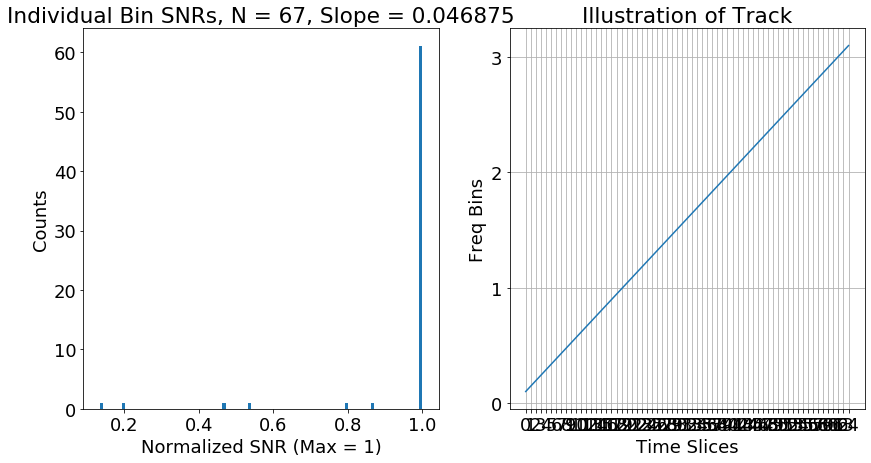

Mean Bin SNR:  0.9552238805970149


In [9]:
IndividualBin_SNR_Hist(a = 3, b = 64, y_int = .10, Bins = 100)

In [325]:
# When we call interact, we pass fixed(20) for q to hold it fixed at a value of 20.

interact(IndividualBin_SNR_Hist, a=(1,10,1),b =(1,10,1), y_int=(0.0,1.0,.01), Bins = fixed(100));

interactive(children=(IntSlider(value=6, description='a', max=10, min=1), IntSlider(value=5, description='b', …

## 3. Impose a Power Cut. 

What fraction of the Bins that the track traverses survive the power cut as a function of slope and then how does this effect the mean SNR? 
Average the effect over all y-intercepts. 


In [249]:
def IndividualBin_SNR_Array(a = 6, b = 5, y_int = .10):
    
    if np.gcd(a,b) != 1: 
#         print('ERROR: GCD != 1.')
        return None
    if not 0 < y_int < 1:
#         print('ERROR: y_int not in interval (0,1) exclusive.')
        return None 
    else:
        # Define Slope: 
        m = a/b

        # Construct x, y arrays: 
        x = np.arange(0,b+1,1)
        y = np.arange(1,a+1,1)

        x_i = (y-y_int)/m

        SNR = np.concatenate((x,x_i))
        SNR.sort()
        SNR_i = SNR[1:]-SNR[:-1]
        return SNR_i

In [250]:
def FractionAboveThreshold(a = 6, b = 5, y_int = .10, SNR_Cut = .5): 
    
    if IndividualBin_SNR_Array(a, b, y_int) is None: 
#         print('ERROR Thrown')
        return None
    else: 
        SNR_i = IndividualBin_SNR_Array(a, b, y_int)
        FractionAbove = SNR_i[SNR_i>SNR_Cut].shape[0]/(a+b)
        return FractionAbove

In [251]:
FractionAboveThreshold(a = 5, b = 7, y_int = .10, SNR_Cut = .65)

0.5

In [252]:
def FractionAboveThreshold_Avg_y_int(a = 5, b = 7, SNR_Cut = .65): 
    
    if IndividualBin_SNR_Array(a, b, y_int=.2) is None: 
#         print('ERROR Thrown')
        return None

    else: 
        y_int_range = np.arange(1e-3,1,1e-3)
        FractionAbove_Array = np.zeros(y_int_range.shape)
        
        for i,y_int in enumerate(y_int_range):
            FractionAbove_Array[i] = FractionAboveThreshold(a, b, y_int, SNR_Cut)
            
        return (FractionAbove_Array.mean(),FractionAbove_Array.std())
        


In [253]:
FractionAboveThreshold_Avg_y_int(a = 5, b = 9, SNR_Cut = .65)

(0.5357500357500357, 0.03571426782137043)

In [263]:
# Now look at the fraction above threshold as a function of slope: 
from fractions import Fraction

def FractionAboveThreshold_vs_Slope(SNR_Cut = .65):
    
    a_Array  = np.arange(1,10,1)
    b_Array  = np.arange(1,20,1)
    FractionAbove_Array = []
    
    for a in a_Array: 
        for b in b_Array: 

            if FractionAboveThreshold_Avg_y_int(a, b, SNR_Cut) is None:
#                 print('ERROR Thrown')
                break
            else: 
                frac = FractionAboveThreshold_Avg_y_int(a, b, SNR_Cut)
                FractionAbove_Array.append((a/b,frac[0]))
                
                
    slope,FracAbove = zip(*FractionAbove_Array)                                      
    data = {'Slope': slope, 'FractionAboveThreshold': FracAbove}
    SNR_Effect_df = pd.DataFrame(data)
    SNR_Effect_df = SNR_Effect_df.sort_values(by='Slope', ascending=True)
        

    plt.rcParams.update({'font.size': 18})
    fig, axs = plt.subplots(figsize = (12,8))
    axs.set_ylabel('Fraction Above Threshold ')
    axs.set_xlabel('Slope')
    axs.set_title('Fraction of Bins Above Threshold vs Slope, SNR_Cut = {}'.format(SNR_Cut))
    axs.plot(SNR_Effect_df['Slope'],SNR_Effect_df['FractionAboveThreshold'])
    axs.set_xlim((0,3))
    plt.show()
    return None
    

In [264]:
interact(FractionAboveThreshold_vs_Slope, SNR_Cut = (0,1,.05));

interactive(children=(FloatSlider(value=0.65, description='SNR_Cut', max=1.0, step=0.05), Output()), _dom_clas…

## Next: Think about how these "lost" bins effect the SNR we measure. Think about in the context of the Vaunix signal. 